### 🔹 Paso 1: Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

### 🔹 Paso 2: Cargar y explorar los datos

In [ ]:
waze = pd.read_csv("waze_dataset.csv")
print(waze.head())
print(waze.info())

   ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   
3   3  retained        49      40       67.589221                       15   
4   4  retained        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days   device  
0              1985.775061           

### 🔹 Paso 3: Preprocesamiento de datos

In [24]:
waze = waze.dropna(subset=['label'])
waze['churned'] = waze['label'].map({'retained': 0, 'churned': 1})
waze = pd.get_dummies(waze, columns=['device'], drop_first=True)
waze.drop(['ID', 'label'], axis=1, inplace=True)
print(waze.head())
print(waze.info())

   sessions  drives  total_sessions  n_days_after_onboarding  \
0       283     226      296.748273                     2276   
1       133     107      326.896596                     1225   
2       114      95      135.522926                     2651   
3        49      40       67.589221                       15   
4        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days  churned  \
0              1985.775061             28            19        0   
1              3160.472914             13           

### 🔹 Paso 4: Separar variables predictoras y objetivo

In [25]:
X = waze.drop("churned", axis=1)
y = waze["churned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 🔹 Paso 5: Modelo Random Forest

In [26]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2337
           1       0.48      0.12      0.19       523

    accuracy                           0.82      2860
   macro avg       0.66      0.55      0.54      2860
weighted avg       0.77      0.82      0.77      2860

ROC-AUC: 0.7180615929134032


### 🔹 Paso 6: Random Forest con balanceo

In [27]:
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced.predict(X_test)
print("Random Forest con class_weight='balanced'")
print(classification_report(y_test, y_pred_rf_balanced))
print("ROC-AUC:", roc_auc_score(y_test, rf_balanced.predict_proba(X_test)[:, 1]))

Random Forest con class_weight='balanced'
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2337
           1       0.49      0.07      0.13       523

    accuracy                           0.82      2860
   macro avg       0.66      0.53      0.51      2860
weighted avg       0.76      0.82      0.76      2860

ROC-AUC: 0.7201802248474332


### 🔹 Paso 7: Modelo XGBoost

In [28]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

XGBoost Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      2337
           1       0.38      0.16      0.22       523

    accuracy                           0.80      2860
   macro avg       0.61      0.55      0.55      2860
weighted avg       0.75      0.80      0.76      2860

ROC-AUC: 0.684070620519026


### 🔹 Paso 8: Importancia de variables

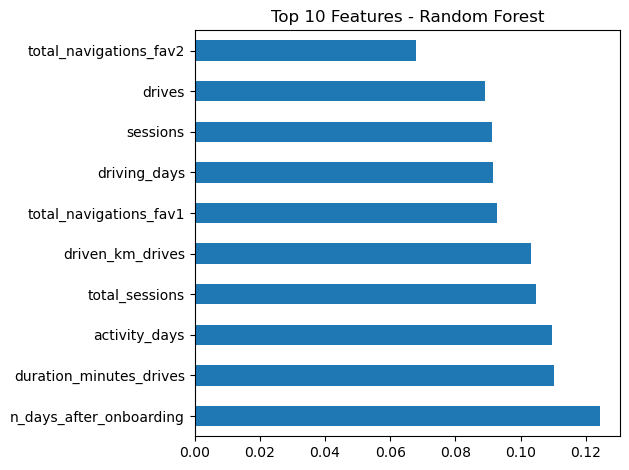

In [29]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features - Random Forest")
plt.tight_layout()
plt.show()

### 🔹 Paso 9: Análisis de usuarios recientes

In [30]:
X_test['es_reciente'] = X_test['n_days_after_onboarding'] < 500
print(X_test['es_reciente'].value_counts())
recientes_idx = X_test['es_reciente']
print(classification_report(y_test[recientes_idx], y_pred_xgb[recientes_idx]))

es_reciente
False    2429
True      431
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       320
           1       0.38      0.23      0.29       111

    accuracy                           0.71       431
   macro avg       0.57      0.55      0.55       431
weighted avg       0.67      0.71      0.68       431



### 🔹 Paso 10: Comparación de grupos

In [31]:
fn_idx = (y_test == 1) & (y_pred_xgb == 0) & (X_test['es_reciente'])
tp_idx = (y_test == 1) & (y_pred_xgb == 1) & (X_test['es_reciente'])
resto_idx = ~X_test['es_reciente']
variables = ['n_days_after_onboarding', 'drives', 'sessions', 'total_navigations_fav1']
comparacion = pd.DataFrame({
    'Falsos Negativos': X_test.loc[fn_idx, variables].mean(),
    'Verdaderos Positivos': X_test.loc[tp_idx, variables].mean(),
    'Usuarios No Recientes': X_test.loc[resto_idx, variables].mean()
})
print(comparacion)

                         Falsos Negativos  Verdaderos Positivos  \
n_days_after_onboarding        276.858824            208.961538   
drives                          65.858824             63.346154   
sessions                        78.670588             75.730769   
total_navigations_fav1         108.952941            264.115385   

                         Usuarios No Recientes  
n_days_after_onboarding            1969.717168  
drives                               65.981062  
sessions                             79.202141  
total_navigations_fav1              118.163853  


### 🔹 Paso 11: Visualización comparativa

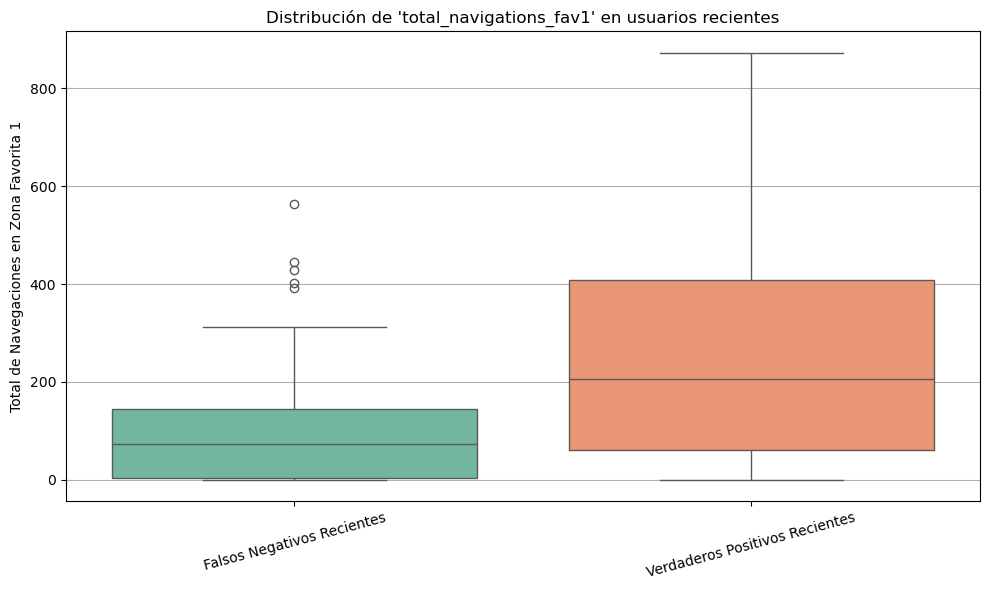

In [32]:
X_test_plot = X_test.copy()
X_test_plot['grupo'] = 'Otro'
X_test_plot.loc[fn_idx, 'grupo'] = 'Falsos Negativos Recientes'
X_test_plot.loc[tp_idx, 'grupo'] = 'Verdaderos Positivos Recientes'
mask = X_test_plot['grupo'].isin(['Falsos Negativos Recientes', 'Verdaderos Positivos Recientes'])
plt.figure(figsize=(10,6))
sns.boxplot(
    data=X_test_plot[mask],
    x='grupo',
    y='total_navigations_fav1',
    hue='grupo',
    palette='Set2',
    legend=False
)
plt.title("Distribución de 'total_navigations_fav1' en usuarios recientes")
plt.ylabel("Total de Navegaciones en Zona Favorita 1")
plt.xlabel("")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 🔍 Análisis comparativo de variables entre grupos

Se compararon las medias de variables clave entre tres grupos de usuarios:

- **Falsos Negativos Recientes**: Usuarios recientes que hicieron churn pero no fueron detectados por el modelo.
- **Verdaderos Positivos Recientes**: Usuarios recientes que hicieron churn y fueron correctamente identificados.
- **Usuarios No Recientes**: Usuarios antiguos, usados como grupo de referencia.

| Variable                     | Falsos Negativos Recientes | Verdaderos Positivos Recientes | Usuarios No Recientes |
|-----------------------------|-----------------------------|-------------------------------|------------------------|
| `n_days_after_onboarding`   | 276.86                      | **208.96**                    | 1969.72               |
| `drives`                    | 65.86                       | 63.35                         | **65.98**             |
| `sessions`                  | 78.67                       | 75.73                         | **79.20**             |
| `total_navigations_fav1`    | 108.95                      | **264.12**                    | 118.16                |

---

### ✅ Conclusión profesional:

- **`total_navigations_fav1`** se destaca como una de las variables más relevantes para predecir correctamente el churn: los usuarios recientes que interactúan mucho con su zona favorita son **mejor detectados por el modelo**.
- Los verdaderos positivos recientes muestran **una mayor actividad de navegación** que los falsos negativos, lo que sugiere que el modelo aprende mejor cuando hay señales claras de comportamiento geográfico.
- **La antigüedad (`n_days_after_onboarding`) también influye**, ya que los usuarios que hicieron churn y fueron bien detectados tenían menor tiempo desde el onboarding.
- El número de **conducciones (`drives`) y sesiones (`sessions`) no presentan grandes diferencias**, por lo que podrían no ser tan útiles por sí solos para discriminar el churn.

---

### 📌 Esto respalda la leyenda del gráfico:

> *"Usuarios recientes que interactúan más con su zona favorita tienen mayor probabilidad de ser correctamente identificados por el modelo."*


In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Asegúrate que X_test solo tenga columnas usadas en X_train
X_test_sync = X_test[X_train.columns]

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Entrenar Random Forest con datos balanceados
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_resampled, y_resampled)

# Predecir en conjunto de prueba sincronizado
y_pred_smote = rf_smote.predict(X_test_sync)
y_prob_smote = rf_smote.predict_proba(X_test_sync)[:, 1]

# Evaluar resultados
print("Random Forest + SMOTE Report:")
print(classification_report(y_test, y_pred_smote, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_smote))


Random Forest + SMOTE Report:
              precision    recall  f1-score   support

Retenido (0)       0.87      0.79      0.83      2337
   Churn (1)       0.34      0.49      0.40       523

    accuracy                           0.73      2860
   macro avg       0.60      0.64      0.61      2860
weighted avg       0.77      0.73      0.75      2860

ROC-AUC: 0.6994733487638791


In [34]:
# Asegurarse que X_test tenga las mismas columnas que X_train / X_resampled
X_test_sync = X_test[X_train.columns]

# Ahora usa X_test_sync para predecir
y_prob = rf_smote.predict_proba(X_test_sync)[:, 1]

umbral = 0.3
y_pred_umbral = (y_prob >= umbral).astype(int)

print(f"Reporte con umbral = {umbral}:")
print(classification_report(y_test, y_pred_umbral, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Reporte con umbral = 0.3:
              precision    recall  f1-score   support

Retenido (0)       0.91      0.55      0.69      2337
   Churn (1)       0.28      0.77      0.41       523

    accuracy                           0.59      2860
   macro avg       0.60      0.66      0.55      2860
weighted avg       0.80      0.59      0.63      2860

ROC-AUC: 0.6994733487638791


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Definir rango de parámetros para GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

# Crear objeto GridSearch con validación cruzada 3-fold
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar búsqueda de parámetros
grid_search.fit(X_train, y_train)

# Mostrar mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Mejor modelo
best_rf = grid_search.best_estimator_

# Sincronizar columnas de X_test con X_train (para evitar errores)
X_test_sync = X_test[X_train.columns]

# Predecir con conjunto de prueba sincronizado
y_pred_best = best_rf.predict(X_test_sync)
y_prob_best = best_rf.predict_proba(X_test_sync)[:, 1]

# Evaluar modelo optimizado
print("Reporte modelo optimizado:")
print(classification_report(y_test, y_pred_best, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros encontrados:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Reporte modelo optimizado:
              precision    recall  f1-score   support

Retenido (0)       0.91      0.68      0.78      2337
   Churn (1)       0.32      0.68      0.44       523

    accuracy                           0.68      2860
   macro avg       0.61      0.68      0.61      2860
weighted avg       0.80      0.68      0.72      2860

ROC-AUC: 0.742829418834593


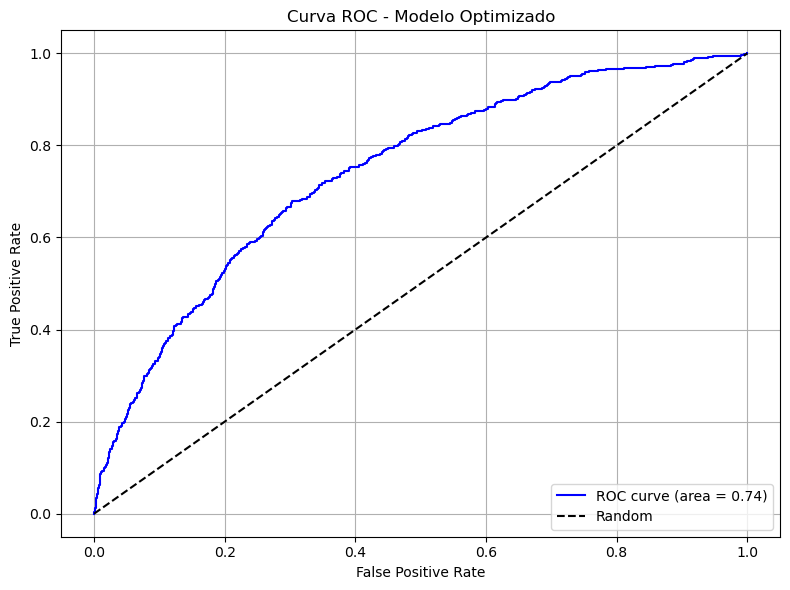

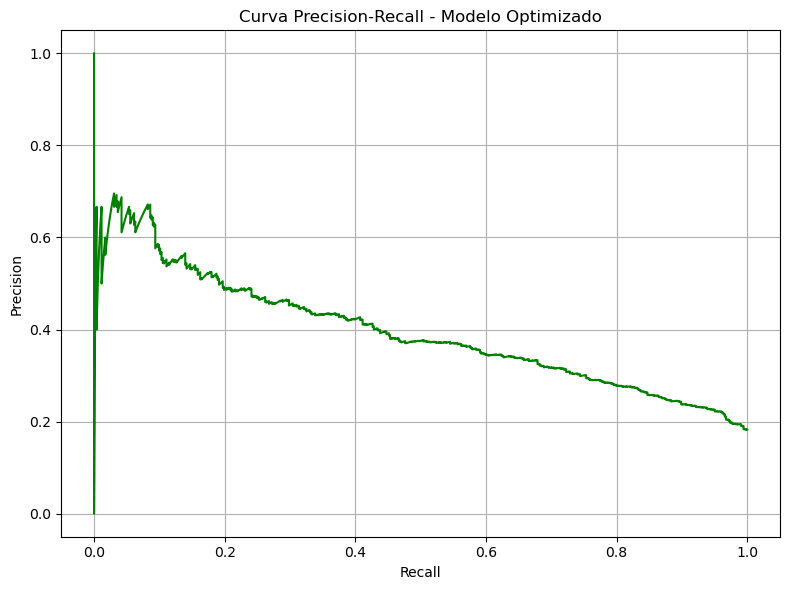

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Variables requeridas que deberían ya estar disponibles en tu entorno de ejecución:
# y_test, y_prob_best

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo Optimizado')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Modelo Optimizado')
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# PASOS ADICIONALES PARA MEJORAR EL MODELO DE CHURN - WAZE

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Asegúrate de haber cargado tu dataset previamente y aplicado el preprocesamiento inicial
# Dataset limpio con variable 'churned' y sin columnas innecesarias
# Supongamos que la variable X, y ya están definidas desde tu código previo

# ----------------------------------------------------------
# 1. INGENIERÍA DE VARIABLES ADICIONALES
X['km_per_drive'] = X['driven_km_drives'] / (X['drives'] + 1)
X['km_per_driving_day'] = X['driven_km_drives'] / (X['driving_days'] + 1)
X['sessions_per_day'] = X['sessions'] / (X['activity_days'] + 1)
X['percent_drives_to_fav'] = X['total_navigations_fav1'] / (X['drives'] + 1)

# ----------------------------------------------------------
# 2. DIVISIÓN EN TRAIN - VALIDATION - TEST (60% / 20% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# ----------------------------------------------------------
# 3. GRID SEARCH CON VALIDACIÓN
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar sobre train
grid_search.fit(X_train, y_train)

# ----------------------------------------------------------
# 4. EVALUAR SOBRE VALIDATION Y TEST
best_model = grid_search.best_estimator_
print("\nMejores parámetros:", grid_search.best_params_)

# VALIDATION
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]
print("\nEvaluación en VALIDACIÓN")
print(classification_report(y_val, y_val_pred, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC Validation:", roc_auc_score(y_val, y_val_prob))

# TEST FINAL
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]
print("\nEvaluación FINAL en TEST")
print(classification_report(y_test, y_test_pred, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC Test:", roc_auc_score(y_test, y_test_prob))


Fitting 3 folds for each of 24 candidates, totalling 72 fits

Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

Evaluación en VALIDACIÓN
              precision    recall  f1-score   support

Retenido (0)       0.91      0.70      0.79      2353
   Churn (1)       0.32      0.67      0.44       507

    accuracy                           0.69      2860
   macro avg       0.62      0.68      0.61      2860
weighted avg       0.80      0.69      0.73      2860

ROC-AUC Validation: 0.7521557523192097

Evaluación FINAL en TEST
              precision    recall  f1-score   support

Retenido (0)       0.90      0.69      0.78      2353
   Churn (1)       0.31      0.65      0.42       507

    accuracy                           0.69      2860
   macro avg       0.61      0.67      0.60      2860
weighted avg       0.80      0.69      0.72      2860

ROC-AUC Test: 0.7351192946014614


Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎯 Mejores parámetros encontrados: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

📊 Evaluación en VALIDACIÓN
              precision    recall  f1-score   support

Retenido (0)       0.91      0.70      0.79      2353
   Churn (1)       0.33      0.67      0.44       507

    accuracy                           0.70      2860
   macro avg       0.62      0.69      0.62      2860
weighted avg       0.80      0.70      0.73      2860

ROC-AUC Validation: 0.7520526483879324

🧪 Evaluación FINAL en TEST
              precision    recall  f1-score   support

Retenido (0)       0.90      0.69      0.78      2353
   Churn (1)       0.31      0.64      0.41       507

    accuracy                           0.68      2860
   macro avg       0.60      0.66      0.60      2860
weighted avg       0.79      0.68      0.72      2860

ROC-AUC Test: 0.7337739140347923


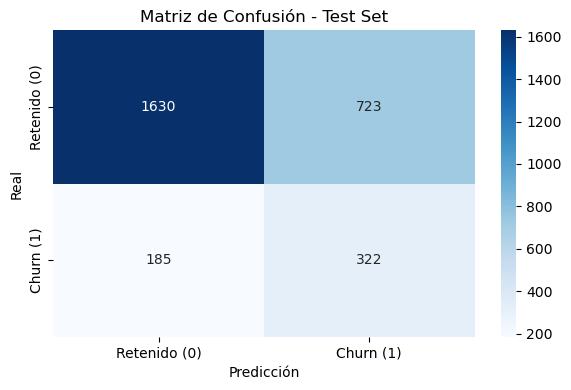

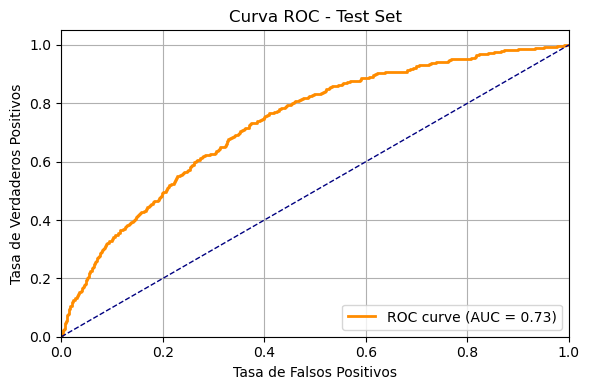

In [51]:
# ------------------------------
# 0. LIBRERÍAS
# ------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. CARGA DE DATOS
# ------------------------------
df = pd.read_csv("waze_dataset.csv")
df.columns = df.columns.str.strip()

# ------------------------------
# 2. NORMALIZA Y FILTRA LABELS VÁLIDAS
# ------------------------------
df["label"] = df["label"].astype(str).str.strip().str.lower()

valores_validos = {"retained": 0, "churned": 1}
df = df[df["label"].isin(valores_validos.keys())].copy()
df["label"] = df["label"].map(valores_validos)

# ------------------------------
# 3. DEFINE X E Y
# ------------------------------
X = df.drop(columns=["label"])
y = df["label"]

# ------------------------------
# 4. INGENIERÍA DE VARIABLES
# ------------------------------
X["km_per_drive"] = X["driven_km_drives"] / (X["drives"] + 1)
X["km_per_driving_day"] = X["driven_km_drives"] / (X["driving_days"] + 1)
X["sessions_per_day"] = X["sessions"] / (X["activity_days"] + 1)
X["percent_drives_to_fav"] = X["total_navigations_fav1"] / (X["drives"] + 1)

# ------------------------------
# 5. ONE-HOT ENCODING PARA DEVICE
# ------------------------------
X = pd.get_dummies(X, columns=["device"], drop_first=True)

# ------------------------------
# 6. LIMPIEZA DE NULOS
# ------------------------------
X["label"] = y
X = X.dropna()
y = X["label"]
X = X.drop(columns=["label"])

# ------------------------------
# 7. SPLIT EN TRAIN / VAL / TEST
# ------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# ------------------------------
# 8. GRID SEARCH
# ------------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("🎯 Mejores parámetros encontrados:", grid_search.best_params_)

# ------------------------------
# 9. VALIDACIÓN
# ------------------------------
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

print("\n📊 Evaluación en VALIDACIÓN")
print(classification_report(y_val, y_val_pred, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC Validation:", roc_auc_score(y_val, y_val_prob))

# ------------------------------
# 10. TEST FINAL
# ------------------------------
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

print("\n🧪 Evaluación FINAL en TEST")
print(classification_report(y_test, y_test_pred, target_names=["Retenido (0)", "Churn (1)"]))
print("ROC-AUC Test:", roc_auc_score(y_test, y_test_prob))

# ------------------------------
# 11. MATRIZ DE CONFUSIÓN
# ------------------------------
cm = confusion_matrix(y_test, y_test_pred)
labels = ["Retenido (0)", "Churn (1)"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión - Test Set")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# ------------------------------
# 12. CURVA ROC
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

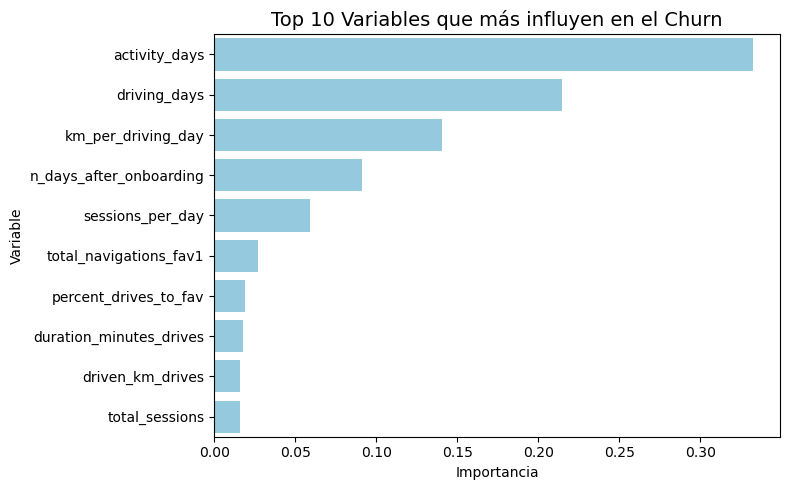

In [53]:
importances = best_model.feature_importances_
features = X.columns
importancia_df = pd.DataFrame({"feature": features, "importancia": importances})
importancia_df = importancia_df.sort_values(by="importancia", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x="importancia", y="feature", data=importancia_df, color="skyblue")
plt.title("Top 10 Variables que más influyen en el Churn", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()